In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from keras import models
from keras import layers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from keras.applications.xception import Xception
from keras.applications import VGG16
from keras.applications import NASNetLarge
from keras.models import Model
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
import os, shutil

In [2]:
print(len(os.listdir('../pet_data/train_images/')))
print(len(os.listdir('../pet_data/test_images/')))

10331
15040


In [3]:
bread_labels = pd.read_csv('../pet_data/breed_labels.csv')
color_labels = pd.read_csv('../pet_data/color_labels.csv')
state_labels = pd.read_csv('../pet_data/state_labels.csv')
test_sample_submission = pd.read_csv('../pet_data/test/sample_submission.csv')
test = pd.read_csv('../pet_data/test/test.csv')
train = pd.read_csv('../pet_data/train.csv')
train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])
train_folder = '../pet_data/train_images/'
test_folder = '../pet_data/test_images/'

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [4]:
train.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [5]:
test.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
count,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000
mean,1.526089,11.564590,263.033435,57.359422,1.782675,2.232016,3.355623,2.061297,1.824468,1.466819,1.703647,1.506079,1.889311,1.043566,1.626393,27.346251,41351.019250,0.062817,3.809524
std,0.499382,18.568429,59.178121,112.086810,0.692633,1.736614,2.700144,3.041357,0.569772,0.613308,0.664200,0.682930,0.587995,0.218539,1.609914,88.416045,34.708648,0.391324,3.627959
min,1.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000
50%,2.000000,4.000000,266.000000,0.000000,2.000000,2.000000,3.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000
75%,2.000000,12.000000,307.000000,0.000000,2.000000,3.000000,6.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000
max,2.000000,180.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,2400.000000,41401.000000,9.000000,30.000000


In [6]:
merged_sets = pd.merge(train, test, on=['PetID'], how='inner')
merged_sets

,Type_x,Name_x,Age_x,Breed1_x,Breed2_x,Gender_x,Color1_x,Color2_x,Color3_x,MaturitySize_x,...,Sterilized_y,Health_y,Quantity_y,Fee_y,State_y,RescuerID_y,VideoAmt_y,Description_y,PhotoAmt_y,dataset_type_y


In [7]:
train_images = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_images = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

In [8]:
train_images.sort()
test_images.sort()
train_images

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [9]:
pet_id_adopt_rate = pd.DataFrame([train.PetID, train.AdoptionSpeed]).transpose()

In [10]:
pet_id_adopt_rate.describe()

,PetID,AdoptionSpeed
count,14993,14993
unique,14993,5
top,36e1415c8,4
freq,1,4197


In [11]:
image_names = []

for image_name in os.listdir('../pet_data/train_images/'):
    image_names.append(image_name)
# for image_name in os.listdir('../pet_data/test_images/'):
#     image_names.append(image_name)

In [12]:
image_names_df = pd.DataFrame(image_names, columns=['image_name'])
image_names_df.sort_values(by=['image_name'], ascending=True)

,image_name
2282,0008c5398-1.jpg
8241,0008c5398-5.jpg
9539,000fb9572-1.jpg
2837,000fb9572-3.jpg
3270,0011d7c25-1.jpg
8860,00156db4a-5.jpg
474,001a1aaad-1.jpg
6823,001b1507c-2.jpg
155,001b1507c-3.jpg
9503,002278114-10.jpg


pull image ids from image names and place in set to remove duplicates

In [13]:
image_ids = []

for image_id in image_names_df.image_name:
    image_ids.append(image_id[:image_id.index('-')])
    

# image_ids = set(image_ids)
image_ids = list(image_ids)
image_ids.sort()
len(image_ids)

10331

In [14]:
image_names_dataf = pd.DataFrame(image_ids, columns=['PetID'])
image_names_dataf.describe()

,PetID
count,10331
unique,6833
top,be579e6ed
freq,10


In [15]:
merged_images = pd.merge(image_names_dataf, pet_id_adopt_rate, on=['PetID'], how='inner')
merged_images.sort_values('PetID')
merged_images.loc[merged_images['PetID'] == '0008c5398']


,PetID,AdoptionSpeed
0,0008c5398,3
1,0008c5398,3


In [16]:
len(merged_images)

10331

In [17]:
len(image_ids)

10331

In [18]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    

# image_ids = set(image_ids)
# image_ids2 = list(image_ids)
image_ids2.sort()
image_ids2

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [19]:
merged_images.PetID = image_ids2
merged_images

,PetID,AdoptionSpeed
0,0008c5398-1.jpg,3
1,0008c5398-5.jpg,3
2,000fb9572-1.jpg,3
3,000fb9572-3.jpg,3
4,0011d7c25-1.jpg,2
5,00156db4a-5.jpg,1
6,001a1aaad-1.jpg,2
7,001b1507c-2.jpg,1
8,001b1507c-3.jpg,1
9,002278114-10.jpg,1


In [20]:
generator_dict = {'filename': [], 'class': []}

for img in train_images:
    generator_dict['filename'].append(img)
for label in merged_images.AdoptionSpeed:
    generator_dict['class'].append(str(label))

generator_df = pd.DataFrame(generator_dict)
generator_df.head(8)

# train_image_list = []
# train_labels = []

# for img in train_images:
#     train_image_list.append(np.expand_dims(ndimage.imread('../pet_data/train_images/'+img), 0))
# for label in merged_images.AdoptionSpeed:
#     train_labels.append(label)
    

,filename,class
0,0008c5398-1.jpg,3
1,0008c5398-5.jpg,3
2,000fb9572-1.jpg,3
3,000fb9572-3.jpg,3
4,0011d7c25-1.jpg,2
5,00156db4a-5.jpg,1
6,001a1aaad-1.jpg,2
7,001b1507c-2.jpg,1


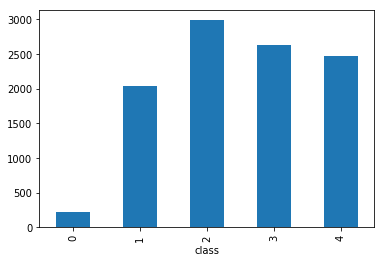

In [45]:
generator_df.groupby('class').size().plot.bar()

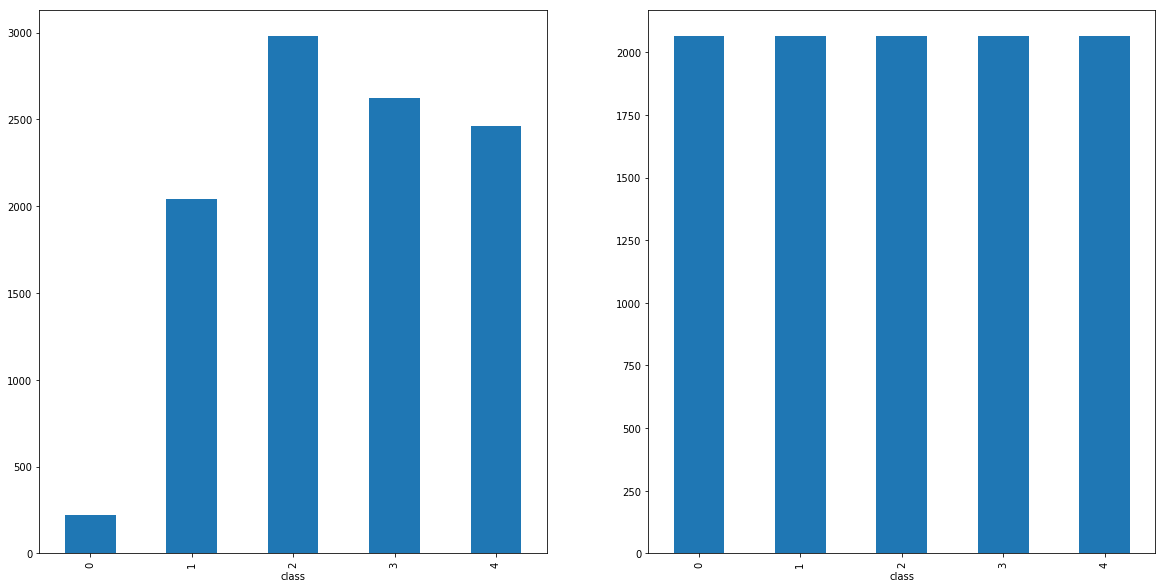

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
generator_df.groupby('class').size().plot.bar(ax=ax1)
train_df = generator_df.groupby('class').apply(lambda x: x.sample(10331//5, replace=True)).reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2)


In [67]:
train_df.groupby('class').size()

class
0    2066
1    2066
2    2066
3    2066
4    2066
dtype: int64

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if sys.path[0] == '':


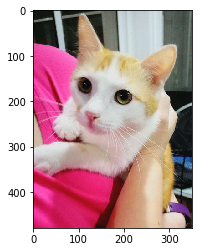

In [21]:
gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.15, 
    zoom_range=0.1,
    channel_shift_range=10.,
    horizontal_flip=True
)

image_path = '../pet_data/train_images/0008c5398-1.jpg'
image = np.expand_dims(ndimage.imread(image_path), 0)
plt.imshow(image[0])

In [59]:
# datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     zca_epsilon=1e-06,  # epsilon for ZCA whitening
#     rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     shear_range=0.1,  # set range for random shear
#     zoom_range=0.1,  # set range for random zoom
#     channel_shift_range=0.,  # set range for random channel shifts
#     # set mode for filling points outside the input boundaries
#     fill_mode='nearest',
#     cval=0.,  # value used for fill_mode = "constant"
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False,  # randomly flip images
#     # set rescaling factor (applied before any other transformation)
#     rescale=1/255.,
#     # set function that will be applied on each input
#     preprocessing_function=None,
#     # image data format, either "channels_first" or "channels_last"
#     data_format=None
# )

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return datagen.flow_from_dataframe(
        train_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(100, 100), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=128, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
val_generator = create_generator('validation')

Found 4377 images belonging to 5 classes.
Found 1458 images belonging to 5 classes.


In [60]:
import keras
keras.__version__

'2.2.4'

In [61]:
generator_df.describe()

,filename,class
count,10331,10331
unique,10331,5
top,1d8dd930a-3.jpg,2
freq,1,2982


In [25]:
len(val_generator)

21

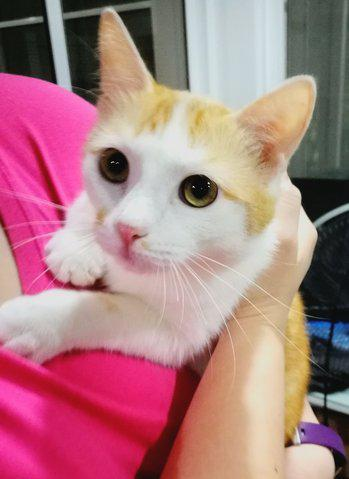

In [26]:
from IPython.display import Image
Image(filename='../pet_data/train_images/0008c5398-1.jpg') 

# image 1 is profile pic, its presumed pics with faces are removed, which explaines why it jumps from 1 to 5 for image name

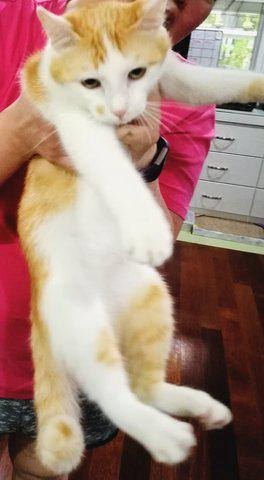

In [26]:
Image(filename='../pet_data/train_images/0008c5398-5.jpg') 

In [62]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))


In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         147584    
__________

In [64]:
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [65]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, 
    epochs=10,
    callbacks=[checkpoint],
    validation_data=val_generator,
    use_multiprocessing=True,
    validation_steps=1,
    workers=2, 
    verbose=1
)

Epoch 1/10


/usr/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 30s 299ms/step - loss: 1.1893 - acc: 0.3296 - val_loss: 3.9454 - val_acc: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 24s 238ms/step - loss: 1.1673 - acc: 0.3362 - val_loss: 4.6719 - val_acc: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 26s 259ms/step - loss: 1.1670 - acc: 0.3343 - val_loss: 5.9530 - val_acc: 0.0000e+00
Epoch 4/10
 41/100 [===========>..................] - ETA: 15s - loss: 1.1740 - acc: 0.3333

Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-23:
Process ForkPoolWorker-24:


KeyboardInterrupt: 

  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/site-packages/keras_preprocessing/image/

# VGG16 model

In [68]:
VGG16_model = VGG16(weights='imagenet', 
                    include_top=False, 
                    input_tensor=None, 
                    input_shape=(100,100,3), 
                    pooling=None, 
                    classes=5)

# plot_model(VGG16_model, to_file='vgg.png')

# Freeze all the layers which I don't want to retrain
#for layer in VGG16_model.layers[:18]:
#for layer in VGG16_model.layers[:14]:
for layer in VGG16_model.layers[:10]:
#for layer in VGG16_model.layers[:6]:
    layer.trainable = False

#Adding custom Layers 
x = VGG16_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
# x = Dropout(0.8)(x)
x = Dense(1024, activation="relu")(x)
# x = Dropout(0.8)(x)
#output layer with 62 classes as possible predictions
predictions = Dense(5, activation="softmax")(x)


vg_model = Model(input = VGG16_model.input, output = predictions)
vg_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='max', 
    period=1)

callbacks_list = [checkpoint]

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [69]:
vg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [70]:
vg_model.fit_generator(
    train_generator,
    steps_per_epoch=75000 / 128, 
    epochs=10,
    callbacks=[checkpoint],
    validation_data=val_generator,
    use_multiprocessing=True,
    validation_steps=1,
    workers=2, 
    verbose=1
)

Epoch 1/10
586/585 [==============================] - 158s 270ms/step - loss: 12.3575 - acc: 0.2312 - val_loss: 11.8367 - val_acc: 0.2656

Epoch 00001: val_acc improved from -inf to 0.26562, saving model to model.h5
Epoch 2/10
573/585 [============================>.] - ETA: 3s - loss: 12.3862 - acc: 0.2315

Process ForkPoolWorker-36:
Process ForkPoolWorker-35:
Process ForkPoolWorker-37:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/site-packages/PIL/ImageFile.py", line 241, in load
    n, err_code = decoder.decode(b)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/lib/python3.7/site-packages/keras_preprocessing/image/iterator.py", line 100, in __next__
    return self.next(*args, **kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/keras_preprocessing/image/iterator.py", line 112, i

# Xception model

In [69]:
xception = Xception(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
xception_model = Model(xception.input, predictions)


In [70]:
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [71]:
for layer in xception.layers:
    layer.trainable = False
    
xception_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

In [73]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

def create_generator(subset):
    return datagen.flow_from_dataframe(
        train_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If 299 extension is given in x_col
        target_size=(299, 299), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=128, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
val_generator = create_generator('validation')

history = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=100, 
    epochs=10,
    callbacks=[checkpoint],
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=2, 
    validation_steps=1,
    verbose=1
)

Found 4668 images belonging to 5 classes.
Found 1167 images belonging to 5 classes.
Epoch 1/10
100/100 [==============================] - 100s 996ms/step - loss: 1.0848 - acc: 0.5292 - val_loss: 3.7420 - val_acc: 0.0156
Epoch 2/10
100/100 [==============================] - 99s 992ms/step - loss: 1.0675 - acc: 0.5317 - val_loss: 3.7618 - val_acc: 0.0234
Epoch 3/10
100/100 [==============================] - 98s 984ms/step - loss: 1.0614 - acc: 0.5397 - val_loss: 3.8736 - val_acc: 0.0078
Epoch 4/10
100/100 [==============================] - 99s 986ms/step - loss: 1.0409 - acc: 0.5402 - val_loss: 4.1786 - val_acc: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 98s 983ms/step - loss: 1.0373 - acc: 0.5456 - val_loss: 3.5353 - val_acc: 0.0312
Epoch 6/10
100/100 [==============================] - 97s 974ms/step - loss: 1.0249 - acc: 0.5616 - val_loss: 3.7569 - val_acc: 0.0156
Epoch 7/10
100/100 [==============================] - 98s 983ms/step - loss: 1.0089 - acc: 0.5709 - v

# NasNet Large

In [32]:
nasnet = NASNetLarge(include_top=False, 
                    weights='imagenet', 
                    input_tensor=None, 
                    pooling=None, 
                    classes=5)

x = nasnet.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)
nasnet_model = Model(nasnet.input, predictions)
nasnet_model.summary()

343613440/343610240 [==============================] - 11s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_________________________________________

In [33]:
for layer in nasnet.layers:
    layer.trainable = False
    
nasnet_model.compile(loss='categorical_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])

In [34]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)


datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

def create_generator(subset):
    return datagen.flow_from_dataframe(
        generator_df, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='class', 
        has_ext=True,  # If 299 extension is given in x_col
        target_size=(331, 331), 
        color_mode='rgb',
        class_mode='categorical', 
        batch_size=128, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
val_generator = create_generator('validation')

history = nasnet_model.fit_generator(
    train_generator,
    steps_per_epoch=75000 / 128, 
    epochs=10,
    callbacks=[checkpoint],
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=2, 
    validation_steps=1,
    verbose=1
)

Found 8265 images belonging to 5 classes.
Found 2066 images belonging to 5 classes.


/usr/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 51/585 [=>............................] - ETA: 35:32 - loss: 1.4670 - acc: 0.2995

Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/

KeyboardInterrupt: 